In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import seaborn as sns

## Classification Trees

First we will demonstrate classification trees. Consider the `Hearts` dataset from the ISL teextbook.

In [3]:
df = pd.read_csv('heart.csv')
df

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

In [4]:
X = df.drop(columns=['target'])
y = df['target']
X

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  
0        0   0     1  
1        0   0     2  
2        2   0     2  
3        2   0     2  
4        2   0     2  
..     ...  ..   ...  
298      1   0     3  
299      1   0     3  
300      1   2     3  
301      1   1     3  
302      1   1     2  

[303 rows x 13 columns]

In [6]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [8]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

Train score 1.0
Test score 0.713768115942029


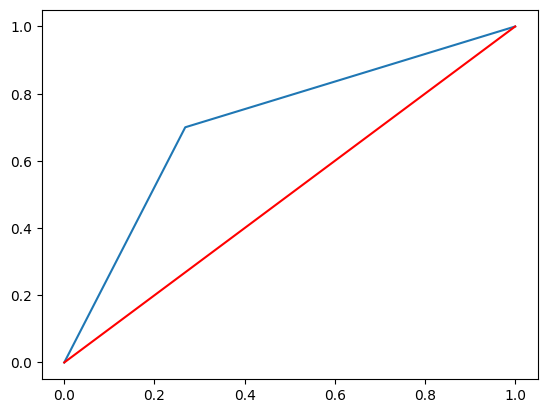

In [10]:
print(f'Train score {roc_auc_score(y_train_pred,y_train)}')
print(f'Test score {roc_auc_score(y_test_pred,y_test)}')

y_pred_probs = clf.predict_proba(X_test)

fpr,tpr,thresholds = roc_curve(y_test,y_pred_probs[:,1])
xgrid = np.linspace(0,1,100)
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')

### Tuning

We will explore the impact on some parameteres, related to when the tree stops, on the prediction

In [11]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00428816 0.00454852 0.00628931 0.00703259 0.00707547
 0.00707547 0.00808625 0.0086478  0.00870827 0.00900515 0.01059252
 0.01273585 0.01346817 0.0140453  0.02642717 0.05250207 0.15772917]


In [12]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

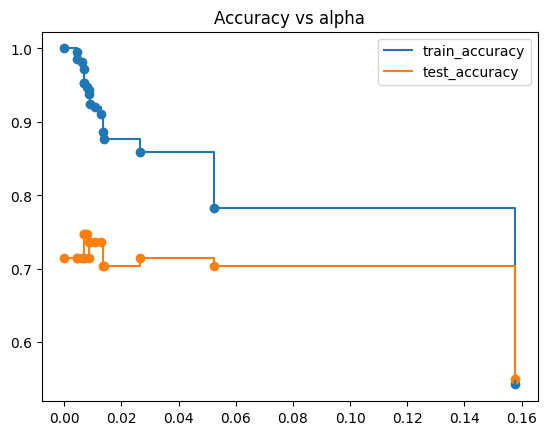

In [13]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

We can choose $\alpha=0.01$

In [14]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.010)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.9245283018867925
Test score 0.7362637362637363


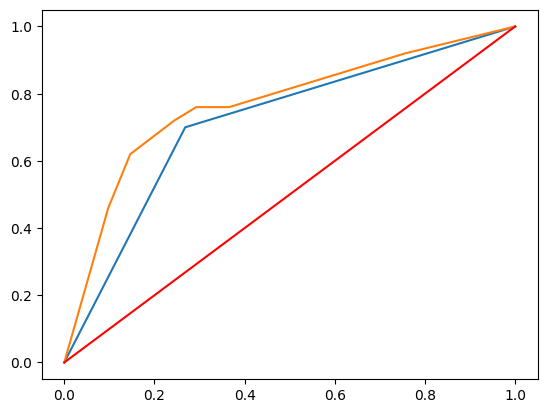

In [15]:
y_pred_probs = clf_.predict_proba(X_test)

fpr_opt,tpr_opt,thresholds = roc_curve(y_test,y_pred_probs[:,1])
xgrid = np.linspace(0,1,100)
plt.plot(fpr,tpr)
plt.plot(fpr_opt,tpr_opt)
plt.plot(xgrid,xgrid,'red')

There is some improvement in the test error and the tree is now shorter and possible to visualise.

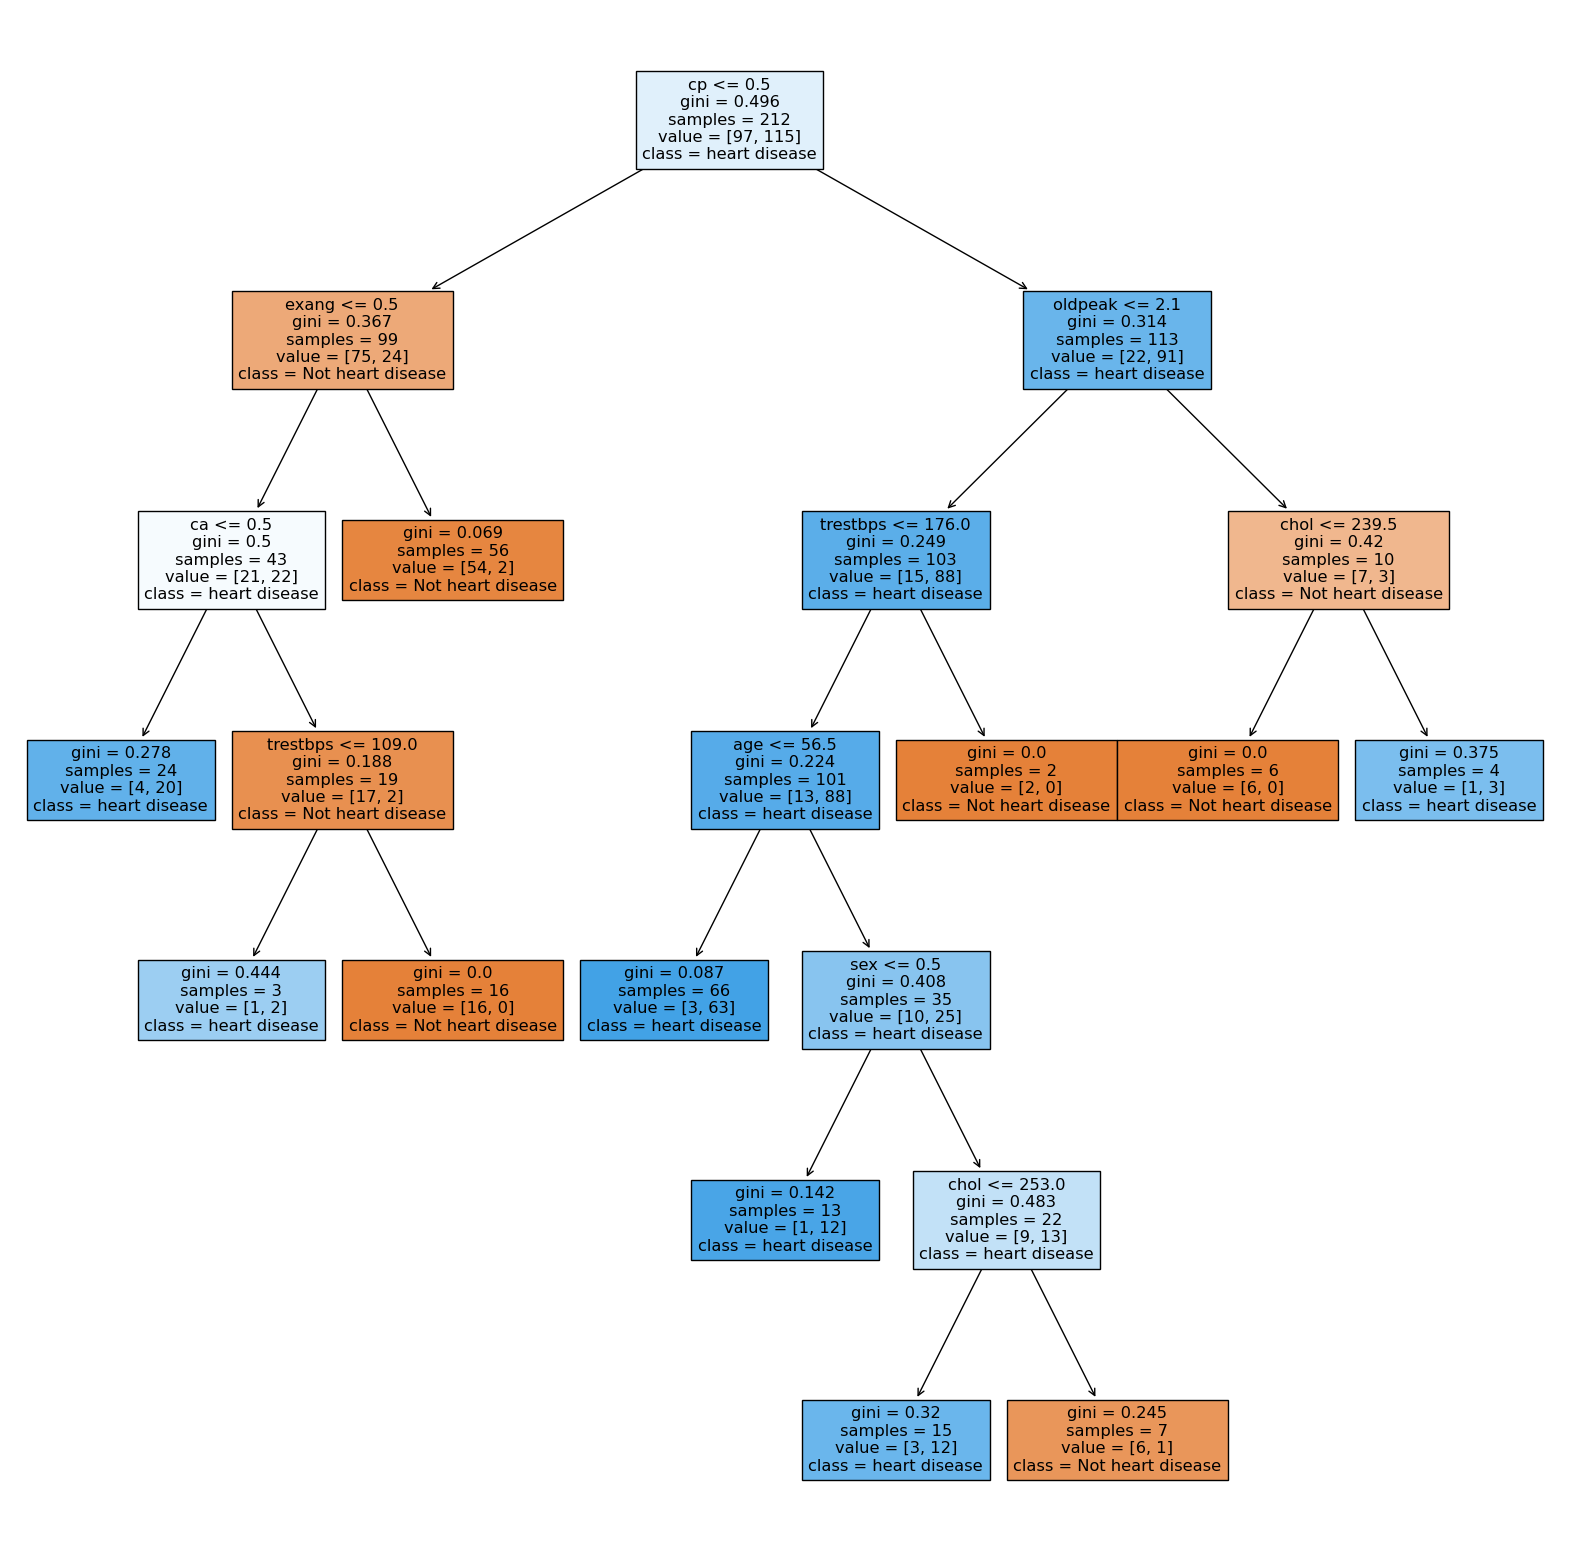

In [16]:
plt.figure(figsize=(20,20))
classes = ['Not heart disease','heart disease']
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()

## Regression Trees

**Activity**: We will work woth the california housing dataset of sklearn. See sklearn documentation for more information.

In [17]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
n_samples, n_features = X.shape

Due to the size of the data and in order to illustrate concepts quickly we work with a small training set (10%)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=5)

We start with ols, ridge and lasso regression

In [19]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)
print('Linear Regression MSE: ',np.mean((y_test - y_pred)**2))

# Ridge
Lambdas = np.linspace(0.5,50,100)
MSEs = np.zeros(100)
for i in range(100):
    ridgereg = Ridge(alpha=Lambdas[i])
    ridgereg.fit(X_train,y_train)
    y_pred = ridgereg.predict(X_test)
    MSEs[i] = np.sum((y_test - y_pred)**2) / len(y_test)
print('Ridge: ',np.min(MSEs),' lambda: ',Lambdas[np.argmin(MSEs)])

# Lasso
Lambdas = np.linspace(1e-2,1,100)
MSEs = np.zeros(100)
lassoreg = {}
for i in range(100):
    lassoreg[i] = Lasso(alpha=Lambdas[i])
    lassoreg[i].fit(X_train,y_train)
    y_pred = lassoreg[i].predict(X_test)
    MSEs[i] = np.sum((y_test - y_pred)**2) / len(y_test)
print('Lasso: ',np.min(MSEs),' lambda: ',Lambdas[np.argmin(MSEs)])

Linear Regression MSE:  0.560703974679841
Ridge:  0.5324558799440533  lambda:  50.0
Lasso:  0.5343121591070711  lambda:  0.01


### Activity 1

Continue by fitting a regression tree. You can use the code for classification tree changing to `DecisionTreeRegressor` from `DecisionTreeClassifier`

In [20]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

## Random Forests and Boosting

Fit a random forest

In [21]:
forest_regr = RandomForestRegressor(max_depth=12, random_state=0)
forest_regr.fit(X_train, y_train)
y_pred = forest_regr.predict(X_test)
print('Random Forest Regression: ',np.mean((y_test - y_pred)**2))

Random Forest Regression:  0.3410178654588924


Use cross validation to tune `max_depth` parameter. This may take some time, be patient.

In [22]:
parameters = {'max_depth': np.arange(10,15)}
forest_regr = RandomForestRegressor(random_state=0)
model = GridSearchCV(estimator=forest_regr, param_grid=parameters)
model.fit(X_train, y_train)
model.best_params_

{'max_depth': 13}

In [23]:
forest_regr = RandomForestRegressor(max_depth=13, random_state=0)
forest_regr.fit(X_train, y_train)
y_pred = forest_regr.predict(X_test)
print('Random Forest Regression - tuned: ',np.mean((y_test - y_pred)**2))

Random Forest Regression - tuned:  0.33964123620202774


In [24]:
gbm_regr = GradientBoostingRegressor(random_state=0)
gbm_regr.fit(X_train, y_train)
y_pred = gbm_regr.predict(X_test)
print('Gradient Boosting Regression: ',np.mean((y_test - y_pred)**2))

Gradient Boosting Regression:  0.3083999900768789


### Activity 2

See if you can further improve by optimising Gradient Boosting. If time permits, also attempt random forest and boosting in the classification example on heart dataset. The relevant functions are `RandomForestClassifier` and `GradientBoostingClassifier`